## Red Neuronal Convolucional

`Deep Learning` forma parte del `Machine Learning`, que a su vez forma parte de la familia de la `Inteligencia Artificial`.

*   El Deep Learning imita las redes neuronales del cerebro humano en el procesamiento de datos, utilizándolo para la toma de decisiones,  detección de objetos, reconocimiento del habla, traducción de idiomas...
*   Aprende sin supervisión ni intervención humana, a partir de datos no estructurados y sin etiquetar.

###### Paso 0 - Instalación de dependencias, importaciones e integración con Gooogle Colab

In [ ]:
# Install dependencies here
#%pip install ___
%pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Include your imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import skimage
from skimage import io
from skimage import transform, filters
from skimage.feature import hog
import torch
import torch.nn as nn
from torch.utils import data
import os
import pickle
import random
import shap

In [ ]:
%matplotlib inline
np.random.seed(0)
mpl.rc("figure", figsize=(12, 12))

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cp -r /gdrive/MyDrive/Data/* /content/
%cd /content

Mounted at /gdrive
/content


##### Paso 1 - Carga de datos

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
[5 7 3 5 5 3 3 1 7 3 3 1]


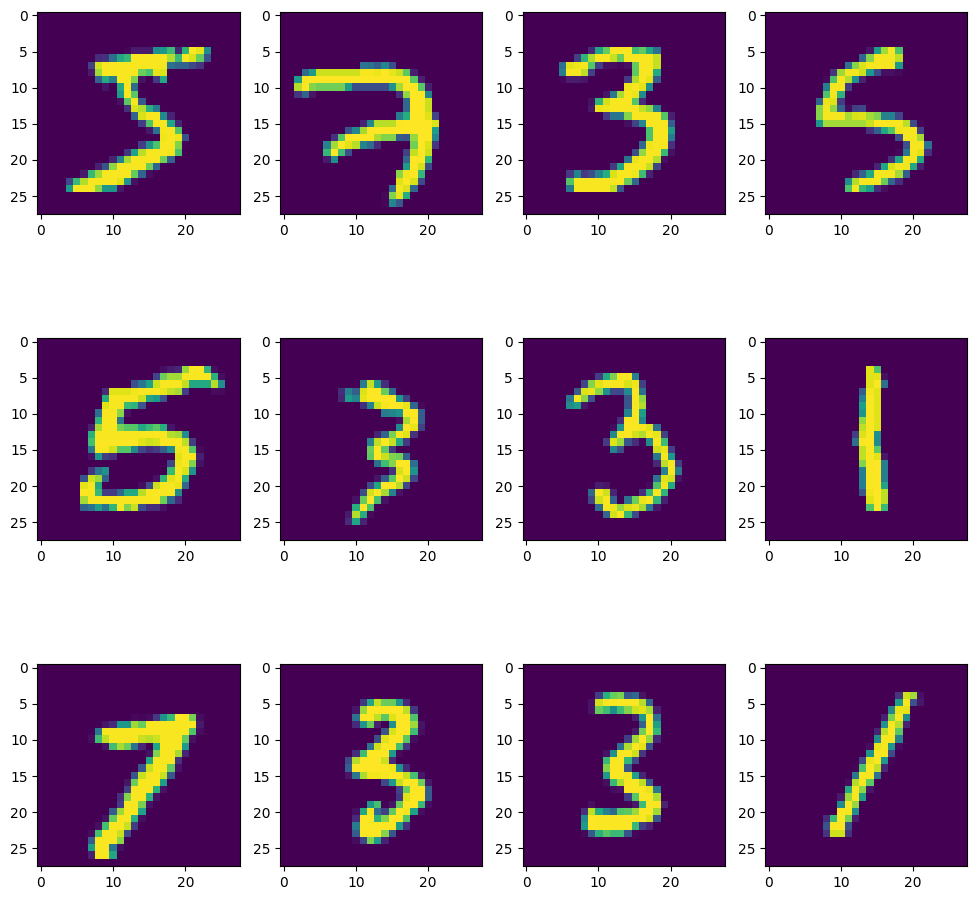

In [ ]:
#MODELO RED NEURONAL CONVOLUCIONAL COMPLETO

#PASO 1 - CARGA DE DATOS (Carga de imágenes desde el pickle)
with open('MNIST_train.dat', 'rb') as f:
    (X_train, y_train) = pickle.load(f)
with open('MNIST_test.dat', 'rb') as f:
    (X_test, y_test) = pickle.load(f)


  #Comprobación del dataset de Train: 60.000 filas y resolución 28x28
print(X_train.shape)
print(y_train.shape)

  #Comprobación del dataset de Test: 10.000 filas y resolución 28x28
print(X_test.shape)
print(y_test.shape)

  #Visualización de imágenes
im = io.imshow_collection(X_train[::5000,:,:])
print(y_train[::5000])

##### Paso 2 - Preprocesamiento de datos

In [ ]:
# ----------------------------------------------------------------------------

#PASO 2 - PREPARACIÓN DATOS

#2.1 NORMALIZACIÓN (Reescalar imágenes: normalizamos los píxeles de -0,5 a 0,5)
def normalize_dataset (dataset):
    scaled_dataset = (dataset / 255.0) - 0.5
    return scaled_dataset

X_train_n = normalize_dataset(X_train)
X_test_n = normalize_dataset(X_test)

  #Comprobación del reescalado
print((np.min(X_train), np.max(X_train)))
print((np.min(X_train_n), np.max(X_train_n)))


#2.2 CONVERTIR VARIABLES A TENSORES PYTORCH
tX_train = torch.tensor(X_train_n, requires_grad=False, dtype=torch.float)
tX_test = torch.tensor(X_test_n, requires_grad=False, dtype=torch.float)
ty_train = torch.tensor(y_train, requires_grad=False, dtype=torch.long)
ty_test = torch.tensor(y_test, requires_grad=False, dtype=torch.long)


#2.3 AJUSTAR DIMENSIONES (Agregar dimensión de canales)
tX_train_c = tX_train.unsqueeze(1)
tX_test_c = tX_test.unsqueeze(1)
ty_train_c = ty_train
ty_test_c = ty_test

  #Comprobación canales
print(tX_train.shape)
print(tX_train_c.shape)



(0, 255)
(-0.5, 0.5)
torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


In [ ]:
type(tX_train_c)

torch.Tensor

##### Paso 3 - Creación de la red neuronal

In [ ]:
# ----------------------------------------------------------------------------

#PASO 3 - CREACIÓN RED NEURONAL CONVOLUCIONAL

#3.1 DEFINICIÓN ESTRUCTURA DE RED

  #Creación de la estructura de red
class neuronal_network(torch.nn.Module):

    def __init__(self):
        super(neuronal_network, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool1 = torch.nn.MaxPool2d(2)
        self.relu1 = torch.nn.LeakyReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool2 = torch.nn.MaxPool2d(2)
        self.relu2 = torch.nn.LeakyReLU()

        self.fc1 = torch.nn.Linear(32*7*7, 10)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.log(self.softmax(x))
        return x

# Crear el modelo nn2
nn2 = neuronal_network()



  #Comprobación de parámetros
print("\nNº parametros total:", np.sum([np.prod(p.shape) for p in nn2.parameters()]))


#Mover tensores y modulos a la GPU
nn2 = nn2.cuda()
tX_train_c = tX_train_c.cuda()
tX_test_c = tX_test_c.cuda()
ty_train_c = ty_train_c.cuda()
ty_test_c = ty_test_c.cuda()


#3.2 ENTRENAMIENTO DE LA RED

  #Semilla
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)

do_seeds(29)


  #Inicialización "Xavier" (inicializa los parámetros con una distribución distinta en cada capa en vez de con valores aleatorios uniformes)
def init_f(forw):
    for nam, param in forw.named_parameters():
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param)
        else:
            param.data.fill_(0.01)

init_f(nn2)


  #Función de loss - NLLLoss (negative log likelihood loss)
def loss_f(x, y, forw):
    return torch.nn.functional.nll_loss(forw(x), y)


  #Función de paso
def t_step(x, y, forw, opt):
    opt.zero_grad() # reseteamos los valores acumulados de las derivadas
    loss = loss_f(x, y, forw) # calculamos la 'loss' con los resultados
    out = loss.item() # almacenamos nuestro valor de loss para devolverlo como resultado intermedio
    loss.backward() # propagamos las derivadas de la 'loss' con respecto a nuestros parámetros
    opt.step() # ejecutamos un paso de nuestro optimizador
    return out


  #Optimizador ADAM
opt2 = torch.optim.Adam(nn2.parameters(), weight_decay=0.008, lr=0.0002)


  #Implementación de mini-batches
batch_size = 500
train_dataset = data.TensorDataset(tX_train_c, ty_train_c)
train_loader = data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle: reordena el dataset en cada epoch

test_dataset = data.TensorDataset(tX_test_c, ty_test_c)
test_loader = data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)



  #Entrenamiento
num_epochs = 24
for i in range(num_epochs):
    for x_j, y_j in train_loader:
        out = t_step(x_j, y_j, nn2, opt2)
    if i%3 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i, out))



Nº parametros total: 28938
Epoch: 0, Loss: 0.7294
Epoch: 3, Loss: 0.2211
Epoch: 6, Loss: 0.1482
Epoch: 9, Loss: 0.1062
Epoch: 12, Loss: 0.1274
Epoch: 15, Loss: 0.1076
Epoch: 18, Loss: 0.0981
Epoch: 21, Loss: 0.1093


##### Paso 4 - Evaluación de resultados

In [ ]:
# ----------------------------------------------------------------------------

#PASO 4 - RESULTADOS

#Función de predicción
def pred_f(x, forw):
    with torch.no_grad():
        _, y_pred = torch.max(forw(x), dim=1)
    return y_pred

#Función de scoring
def score_f(x, y, forw):
    with torch.no_grad():
        y_pred = pred_f(x, forw)
        score = torch.sum(y_pred == y).item() / len(y)
    return score

#Resultados de la red neuronal entrenada
print(score_f(tX_train_c, ty_train_c, nn2))
print(score_f(tX_test_c, ty_test_c, nn2))


#Ejemplo entrenado
print(ty_train_c[0:5]) # etiquetas reales de las 5 primeras imágenes
pd.DataFrame(torch.exp(nn2(tX_train_c[0:5, :])).cpu().detach().numpy()) # probabilidades 5 primeras imágenes

0.97955
0.9821
tensor([5, 0, 4, 1, 9], device='cuda:0')


,0,1,2,3,4,5,6,7,8,9
0,0.000004,3.810408e-07,0.000059,0.141613,1.328555e-08,0.858097,0.000003,0.000055,0.000094,0.000075
1,0.999459,4.267923e-07,0.000242,0.000006,1.045609e-06,0.000006,0.000216,0.000011,0.000021,0.000037
2,0.000002,1.108939e-04,0.000096,0.000171,9.926099e-01,0.000014,0.000016,0.000992,0.000114,0.005874
3,0.000083,9.838266e-01,0.001470,0.000031,2.670961e-03,0.000003,0.000316,0.008404,0.003174,0.000022
4,0.000006,1.092017e-05,0.000071,0.000173,1.222829e-02,0.000016,0.000002,0.004587,0.007525,0.975382


In [ ]:
#Estadísticas del training
tr_stats2 = np.stack([np.array([i,
                                np.mean(list(t_step(x_j, y_j, nn2, opt2) for x_j, y_j in train_loader)),
                                loss_f(tX_train_c, ty_train_c, nn2).item(),
                                loss_f(tX_test_c, ty_test_c, nn2).item(),
                                score_f(tX_train_c, ty_train_c, nn2),
                                score_f(tX_test_c, ty_test_c, nn2)]) for i in range(num_epochs)], axis=0)
tr_stats2_df = pd.DataFrame(tr_stats2, columns=['epoch', 'mean_loss', 'tr_loss', 'te_loss', 'tr_score', 'te_score'])
tr_stats2_df.head()

,epoch,mean_loss,tr_loss,te_loss,tr_score,te_score
0,0.0,0.077071,0.075533,0.066729,0.979933,0.9817
1,1.0,0.076247,0.074610,0.066568,0.980633,0.9821
2,2.0,0.075126,0.074963,0.066461,0.980867,0.9823
3,3.0,0.074893,0.072680,0.065284,0.981450,0.9829
4,4.0,0.074059,0.073284,0.064712,0.980733,0.9820


[None]

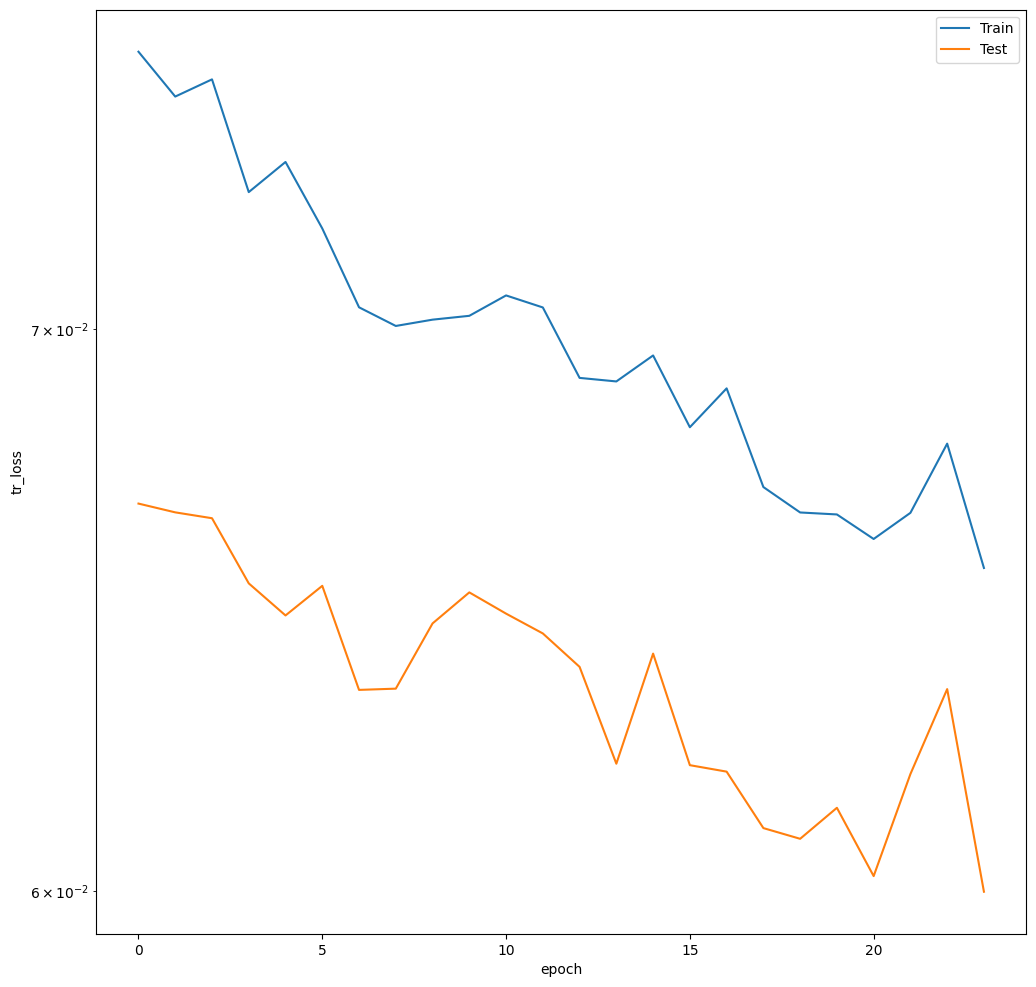

In [ ]:
#Visualización del loss para el training y el testing
ax = sns.lineplot(x='epoch', y='tr_loss', data=tr_stats2_df, label = "Train")
sns.lineplot(x='epoch', y='te_loss', data=tr_stats2_df, ax=ax, label = "Test")
ax.set(yscale="log")

<Axes: xlabel='epoch', ylabel='tr_score'>

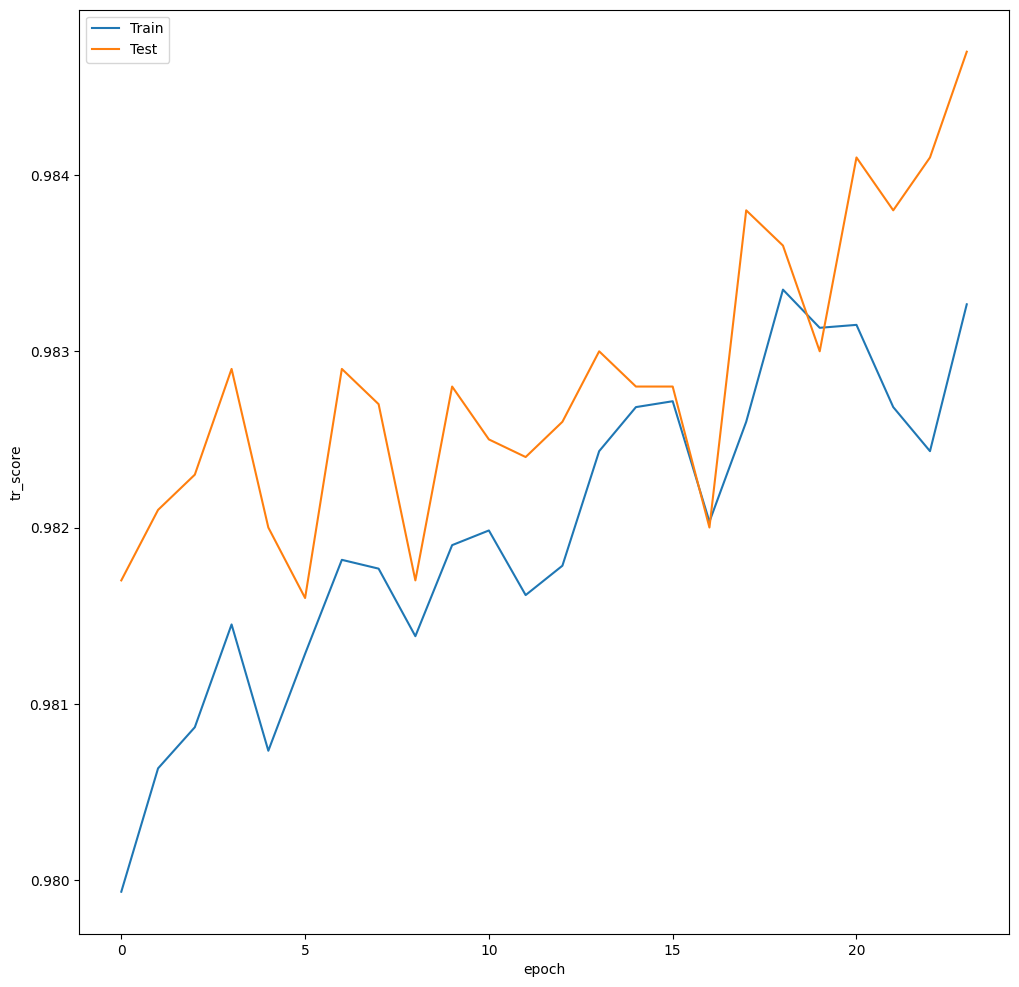

In [ ]:
#Visualización del scoring para el training y el testing
sns.lineplot(x='epoch', y='tr_score', data=tr_stats2_df, label = "Train")
sns.lineplot(x='epoch', y='te_score', data=tr_stats2_df, label = "Test")

In [ ]:
# Guardar el estado del modelo en un archivo
torch.save(nn2.state_dict(), '/Data.pth')